In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)






In [2]:
#Defining class colour
class color:
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [3]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)
def featSelectFilter(attData1):
    # Create correlation matrix
    corr_matrix = corr.abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

    # Get features with correlation greater than 0.75
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

    print(color.BLUE + color.BOLD + 'Features removed since correlation is higher:' + color.END)
    print(to_drop)

    # Drop features 
    attData1.drop(list(to_drop), axis=1, inplace=True)
    
    #Size of the Dataset
    print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
    print(attData1.shape)
    
    return attData1

In [4]:
#Transform the non numerical data into numerical
def transformToNumerical(attData1):
    for column in attData1.columns:
        if attData1[column].dtype == 'int64': #If Column data type is Int i.e, numerical continue
            continue
        attData1[column] = LabelEncoder().fit_transform(attData1[column].astype(str)) #If Column data type is not Int, encode and transform to Numerical
    
    print(color.BLUE + color.BOLD + 'After Encoding to numerical(First 10 records):\n' + color.END)
    print(attData1.head(10)) #Print first 10 records of dataset after encoding
    
    return attData1

In [5]:
#Split the entire dataset to Train and Test 
def splitTrainTest(attData1, attData2):
    X = attData1.iloc[:, 1:attData2.shape[1]] #From the second column, all the columns taken for train dataset
    Y = attData1.iloc[:, 0] #First Column 'Attrition' taken as test dataset
    
    #Split the data into 80% training and 20% testing
    return train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [6]:
#Standardization or z-score normalization
def tranformationZScore(X_train, X_test):
    scaler = StandardScaler()
    
    # Fit on training set only.
    scaler.fit(X_train)
    
    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(color.BLUE + color.BOLD + 'Standardized or z-score Normalized Train and Test Dataset:\n' + color.END)
    print(X_train)
    print(X_test)
    
    return X_train, X_test

In [7]:
#Dimensionality Reduction using PCA
def dimReductionPCA(X_train, X_test):
    # Make an instance of the Model
    pca = PCA(.95)

    pca.fit(X_train)

    X_train = pca.transform(X_train) #PCA transformation on Train Set
    X_test = pca.transform(X_test) #PCA transformation on Test Set

    #How much information (variance) attributed to each of the principal components
    explained_variance = pca.explained_variance_ratio_
    print(color.BLUE + color.BOLD + 'Variance attributed to each of the principal components:' + color.END)
    print(explained_variance)
    
    return X_train, X_test

In [8]:
#Handling the Dataset Imbalance Using Hybridization: SMOTE + Tomek Links
def handleClassImbalance(X_train, Y_train):
    
    counter = Counter(Y_train) #Before Sampling, count of Y_train
    print(color.BLUE + color.BOLD + 'Before Sampling:' + color.END)
    print(counter)

    #Oversampling the train dataset using SMOTE + Tomek
    smtom = SMOTETomek(random_state=0)  #To get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE
    X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, Y_train) #Fit the resampled model

    counter = Counter(y_train_smtom) #After Sampling, Count of y_train_smtom
    print(color.BLUE + color.BOLD + 'After Sampling:' + color.END)
    print(counter)
    
    return X_train_smtom, y_train_smtom

In [9]:
#Train the model using Random Forest classifier - This meta estimator fits a number of decision tree classifiers on sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
def randomForestModel(X_train_smtom, y_train_smtom):
    #Number of trees given as '10' with criterion 'entropy' and seed for random generator is set as '0' 
    randomforest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) 
    randomforest.fit(X_train_smtom, y_train_smtom)

    return randomforest

In [10]:
#Plotting top 6 features that help in predicting using the Random Forest Built-in Feature Importance 
def importantFeatures(randomforest, attData1):
    #Determine the feature importance values
    importances = randomforest.feature_importances_ 
    
    #Create a dictionary with the importances values
    important_features_dict = {}
    for idx, val in enumerate(importances): 
        important_features_dict[idx] = val
    
    #Sort the feature importances in descending order
    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)[1:]

    important_features = attData1.columns[important_features_list]

    #Visualize the top 6 feature importance using bar chart
    feat_importances = pd.Series(importances[important_features_list], index=important_features)
    feat_importances.nlargest(6).plot(kind='barh')
    plt.xlabel('Feature Importance')
    plt.title('Top 6 Features With Higher Random Forest Feature Importance')
    plt.show()

In [30]:
#Create Machine Learning models – Logistic regression and Decision tree to predict
def mlPredict(X_train_smtom, y_train_smtom, Y_test):
    cv_dataFrames = []
    
    # Prepare Machine Learning models – Logistic regression and Decision tree
    models = []
    
    #Parametric Supervised learning model based on probability
    models.append(('Logistic Regression(LR)', LogisticRegression()))
    #Non-Parametric Supervised learning model by learning simple decision rules inferred from the data features
    models.append(('Decision Tree(CART)', DecisionTreeClassifier())) 

    results = []
    mNames = [] #List for collecting model names
    
    #List of scoring metrics for comparison of models
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'] 
    
    targ_names = ['Yes', 'No'] #List of target values
    
    for mName, model in models: #Looping through each of the models
        
            #Split the dataset into '5' folds and Each fold is used once as a validation while the '5 - 1' remaining folds form the training set
            #Shuffle is set to 'True' to shuffle the data before splitting into batches
            #Random_state affects the ordering of the indices, which controls the randomness of each fold
            kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210) 
            
            #Evaluate metrics by cross-validation
            cv_res = model_selection.cross_validate(model, X_train_smtom, y_train_smtom, cv=kfold, scoring=scoring)
            
            #Fit the model and predict the label of test set
            ml = model.fit(X_train_smtom, y_train_smtom) 
            y_pred = ml.predict(X_test)
            
            print(color.BLUE + color.BOLD + mName + color.END)
            
            #Number of correct and incorrect predictions compared wih Actual class and Predicted class
            cm = confusion_matrix(Y_test, y_pred)

            TN = cm[0][0] #True Negative(Model predicted No and the Actual is also No, classifier is getting things right)
            TP = cm[1][1] #True Positive(Model predicted Yes and the Actual is also Yes, classifier is getting things right)
            FN = cm[1][0] #False Negative(Model predicted No and the Actual is Yes, classifier is getting things wrong i.e, mislabelling)
            FP = cm[0][1] #False Positive(Model predicted Yes and the Actual is No, classifier is getting things wrong i.e, mislabelling)

            print(color.BOLD + "\nConfusion Matrix:" + color.END)
            
            column_names = ['Predicted Yes', 'No']
            row_names    = ['Actual Yes', 'No']
            
            cm_df = pd.DataFrame(cm, columns=column_names, index=row_names)
            
            print(cm_df)
            
            #Accuracy determines how often is classifier correct, (TP+TN)/Total
            print(color.BOLD + "\nAccuracy:" + color.END)
            print(round(accuracy_score(Y_test, y_pred) * 100, 2),"%")
            
            #Return the list of scores calculated for each cv='10' folds, estimator object implementing ‘fit’ and n_jobs='-1' means using all processors
            cross_val_lr = cross_val_score(estimator = model, X = X_train_smtom, y = y_train_smtom, cv = 10, n_jobs = -1)
            print(color.BOLD + "\nCross Validation Accuracy:" + color.END)
            print(round(cross_val_lr.mean() * 100 , 2),"%")
            
            #Report showing the main classification metrics with the target names 'Yes' and 'No'
            print(color.BOLD + "\nClassification Report:" + color.END)
            print(classification_report(Y_test, y_pred, target_names=targ_names))
            
            #Get False Positive Rates and True Postive rates for the Classifiers
            #By roc_curve module by passing the test dataset and the predicted data through it
            print(color.BOLD + "\nReceiver Operating Characteristic(ROC):" + color.END)
            false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred)
            
            #Ploting ROC Curves with False Positive Rate on X-axis and True Positive Rate on Y-axis
            title = 'Receiver Operating Characteristic(ROC) - ' + mName
            plt.subplots(1, figsize=(10,10))
            plt.title(title)
            plt.plot(false_positive_rate1, true_positive_rate1)
            plt.plot([0, 1], ls="--")
            plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            
            results.append(cv_res) #Appending the cross validation metrics
            mNames.append(mName) #Appending each of the model names

            dataFrame = pd.DataFrame(cv_res) #Create data frame of cross validation results
            dataFrame['model'] = mName #Add the model name to dataframe
            cv_dataFrames.append(dataFrame) #Append each of the data frames
            
            result = pd.concat(cv_dataFrames, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    return result

In [45]:
#Comparison of Performance of Logistic Regression and Decision tree models
def ml_ModelsComparison(result):
    mlValues = []
    
    #Iterating through result values and append the values of each models to mlValues[]
    for model in list(set(result.model.values)): 
        m_dataFrame = result.loc[result.model == model]
        mlValue = m_dataFrame.sample(n=30, replace=True)
        mlValues.append(mlValue)

    m_dataFrame = pd.concat(mlValues, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    
    #Massage a DataFrame into a format where identifier variable is 'model', variable column 'metrics' and value column 'values'
    perf_results = pd.melt(m_dataFrame,id_vars=['model'],var_name='metrics', value_name='values')
    
    tym_metrics = ['fit_time','score_time'] # Fit time Metrics
    
    #Performance Metrics
    perf_results_nofit = perf_results.loc[~perf_results['metrics'].isin(tym_metrics)] # Get dataframe without fit data
    perf_results_nofit = perf_results_nofit.sort_values(by='values') #Sort the performance result on its values

    #Visualization of Comparison of LR and CART Model using BoxPlot
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.0)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=perf_results_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of LR and CART Model by Classification Metric')

    return perf_results_nofit, m_dataFrame

In [13]:
#Wrapper Method (Greedy Algorithms)
#Removes (backward selection) features to form a feature subset in a greedy fashion.
#At each stage, this estimator chooses the best feature to remove based on the cross-validation score of the estimator "Linear Regression"
def featSelWrapper(attData2):
    #Splitting the dataset
    X = attData2.iloc[:, 1:attData2.shape[1]]
    Y = attData2.iloc[:, 0]
    
    #Sequential backward selection(sbs)
    sbs = SFS(LinearRegression(),
             k_features=25, #25 features selected
             forward=False, #Backward selection
             floating=False, #Sequential
             cv=0) #Cross Validation set to '0'
    
    sbs.fit(X, Y) #Fit the model
    
    #List the features after the sbs method
    list_features = list(sbs.k_feature_names_)
    print(list_features)
    
    return list_features

In [14]:
#Read Data from the csv file
attData = pd.read_csv('Attrition.csv')

#Size of the Dataset
print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
print(attData.shape)

#Replacing to NaN to filter out the datset with NaN/Null values
attData = attData.replace('NAN', np.NaN)

#Count of NaN/Null values from dataset
print(color.BLUE + color.BOLD + "\nCount of NaN/Null values for each feature:" + color.END)
print(attData.isna().sum())


Size of Dataset:
(1470, 33)

Count of NaN/Null values for each feature:
Attrition                   0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            5
Education                   1
EducationField              0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  5
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               5
MonthlyRate                 5
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole         

In [15]:
#Cleaning the missing values in the dataset
columnsList = []
categCols = []
for column in attData:
    columnsList.append(column)
    if len(attData[column].unique()) <= 6: #Distinguishing the categorical features by considering their unique values
        categCols.append(column)
    try:
        if(int(attData[column].iat[0])):
            if abs(attData[column].skew() - 0) < 1e-1:
                attData[column].fillna(int(attData[column].astype(float).mean(skipna=True)), inplace=True) #Filling the NaN with mean of the values for not skewed distribution
            else:
                attData[column].fillna(int(attData[column].astype(float).median(skipna=True)), inplace=True) #Filling the NaN with median of the values for skewed distribution
    except:
        continue

#Count of NaN/Null values after cleaning dataset
print(color.BLUE + color.BOLD + "\nCount of NaN/Null values for each feature after Data cleaning:" + color.END)
print(attData.isna().sum())


Count of NaN/Null values for each feature after Data cleaning:
Attrition                   0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsS

In [16]:
#Character or Numerical Data
print(color.BLUE + color.BOLD + "Categorical Data:" + color.END)
print(categCols)
numCols = list(set(columnsList) - set(categCols))
print(color.BLUE + color.BOLD + "\nNumerical Data:" + color.END)
print(numCols)

Categorical Data:
['Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

Numerical Data:
['TotalWorkingYears', 'PercentSalaryHike', 'YearsInCurrentRole', 'TrainingTimesLastYear', 'DailyRate', 'YearsSinceLastPromotion', 'Age', 'HourlyRate', 'JobRole', 'EmployeeNumber', 'MonthlyIncome', 'NumCompaniesWorked', 'YearsWithCurrManager', 'MonthlyRate', 'YearsAtCompany', 'DistanceFromHome']


Classification of Attrition Data:
No     1233
Yes     237
Name: Attrition, dtype: int64


<AxesSubplot:ylabel='Attrition'>

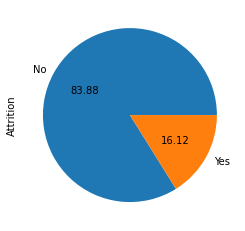

In [17]:
#Balanced or Imbalanced Dataset
print(color.BLUE + color.BOLD + "Classification of Attrition Data:" + color.END)
attritionCount = attData['Attrition'].value_counts()
print(attritionCount)
attritionCount.plot.pie(autopct='%.2f')

In [18]:
#Distribution Of Data
distTxt = color.BLUE + color.BOLD + "Data Distribution" + color.END
print(distTxt.center(120))
attData.describe()

                                             Data Distribution                                             


,Age,DailyRate,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,1024.865306,2.721769,2.729932,2.063946,2.728571,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,602.024335,1.093082,0.711561,1.106940,1.102846,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,491.250000,2.000000,2.000000,1.000000,2.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,1020.500000,3.000000,3.000000,2.000000,3.000000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,1555.750000,4.000000,3.000000,3.000000,4.000000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,2068.000000,4.000000,4.000000,5.000000,4.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [19]:
#Feature Removal from the attData Dataset
attData = attData.drop('Over18', axis = 1) #Since all the rows contain only value 'Yes'
attData = attData.drop('EmployeeNumber', axis = 1) #Since all the rows has a unique number(number assignment)

                                         Correlation Using HeatMap                                         


<AxesSubplot:>

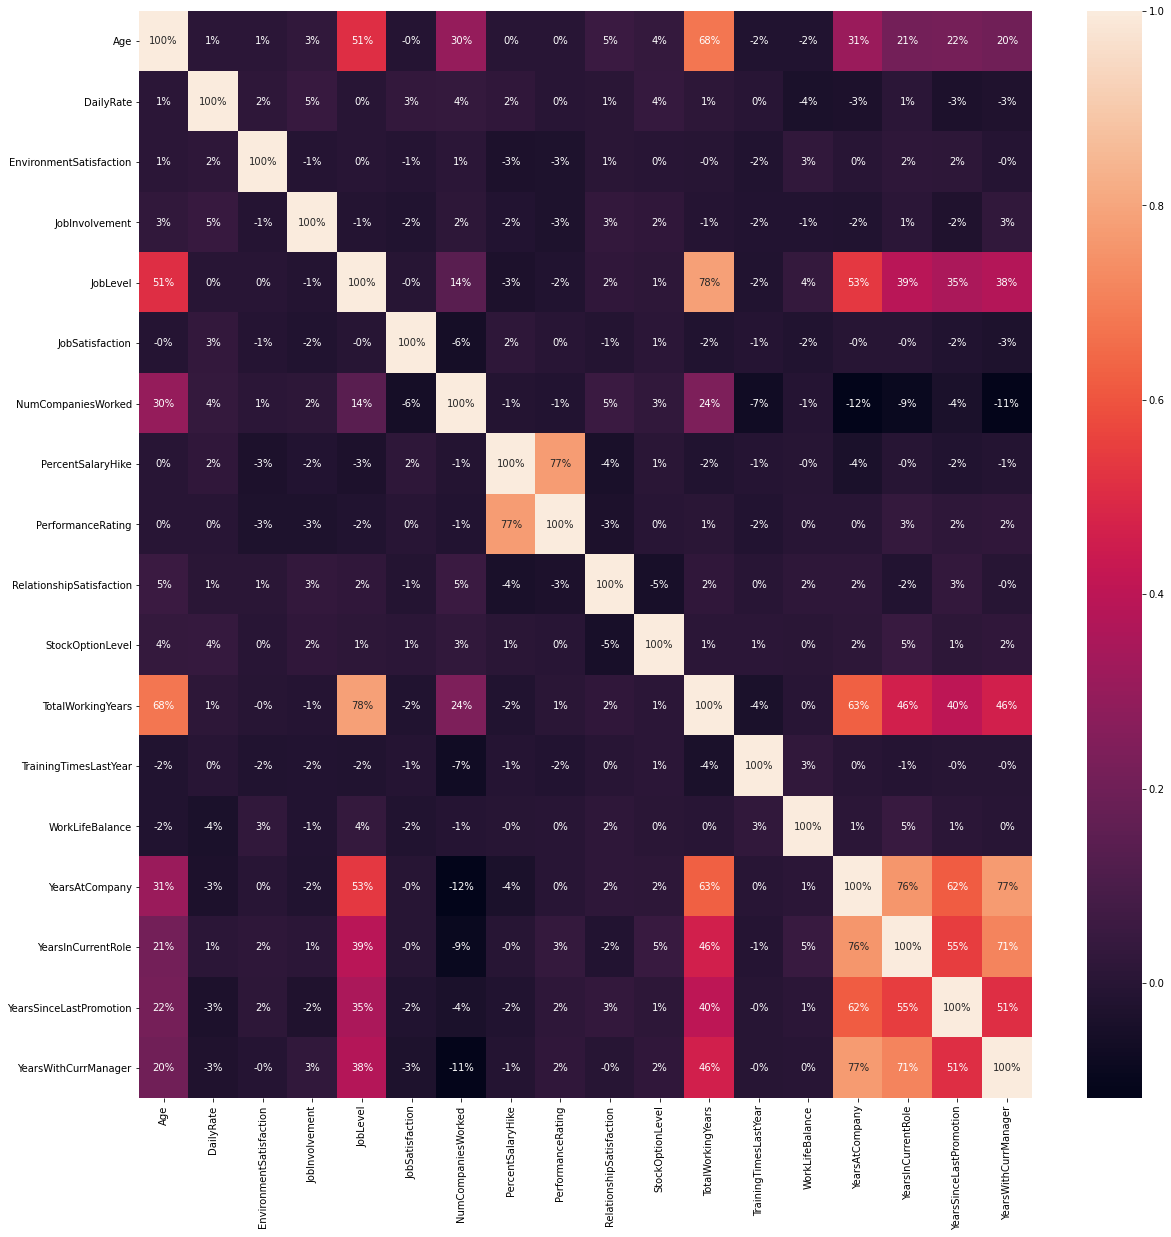

In [20]:
#Correlation of the features in the dataset
corr = attData.corr()

corrTxt = color.BLUE + color.BOLD + "Correlation Using HeatMap" + color.END
print(corrTxt.center(120))

#Visualizing correlation using Heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot = True, fmt = '.0%')

In [21]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)
attDatafilt = attData #Create a copy of attData dataset
attDatafilt = featSelectFilter(attDatafilt)

Features removed since correlation is higher:
['PerformanceRating', 'TotalWorkingYears', 'YearsInCurrentRole', 'YearsWithCurrManager']

Size of Dataset:
(1470, 27)


In [22]:
#Feature Encoding (To Numerical)
attDatafilt = transformToNumerical(attDatafilt)

After Encoding to numerical(First 10 records):

   Attrition  Age  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0          1   41               2       1102           2                 0   
1          0   49               1        279           1                27   
2          1   37               2       1373           1                11   
3          0   33               1       1392           1                22   
4          0   27               2        591           1                11   
5          0   32               1       1005           1                11   
6          0   59               2       1324           1                22   
7          0   30               2       1358           1                16   
8          0   38               1        216           1                15   
9          0   36               2       1299           1                26   

   Education  EducationField  EnvironmentSatisfaction  Gender  ...  \
0          1           

                           Visualization of 'Attrition' against various features                           


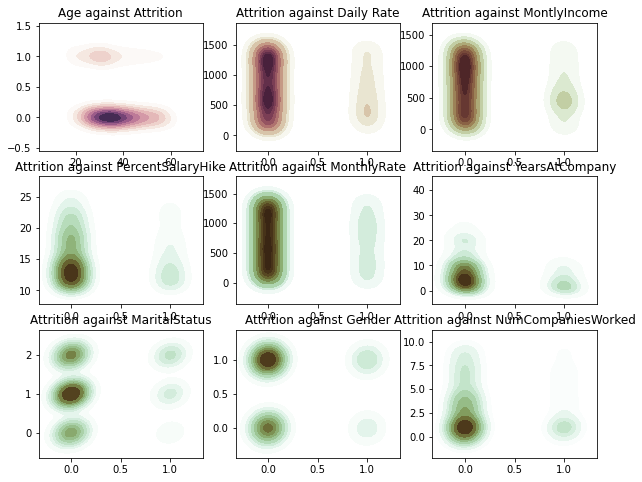

In [23]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#Visualization example of various features against 'Attrition'
f, axes = plt.subplots(3, 3, figsize=(10, 8), 
                       sharex=False, sharey=False)

visTxt = color.BLUE + color.BOLD + "Visualization of 'Attrition' against various features" + color.END
print(visTxt.center(120))

# Defining our colormap scheme
s = np.linspace(0, 3, 10)
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)

# Generate and plot Age against Attrition
x = attDatafilt['Age'].values
y = attDatafilt['Attrition'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=axes[0,0])
axes[0,0].set( title = 'Age against Attrition')

cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)

# Generate and plot Attrition against Daily Rate
x = attDatafilt['Attrition'].values
y = attDatafilt['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set( title = 'Attrition against Daily Rate')

cmap = sns.cubehelix_palette(start=0.666666666667, light=1, as_cmap=True)
# Generate and plot Attrition against MontlyIncome
x = attDatafilt['Attrition'].values
y = attDatafilt['MonthlyIncome'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,2])
axes[0,2].set( title = 'Attrition against MontlyIncome')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

# Generate and plot Attrition against PercentSalaryHike
x = attDatafilt['Attrition'].values
y = attDatafilt['PercentSalaryHike'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[1,0])
axes[1,0].set( title = 'Attrition against PercentSalaryHike')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

# Generate and plot Attrition against MonthlyRate
x = attDatafilt['Attrition'].values
y = attDatafilt['MonthlyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[1,1])
axes[1,1].set( title = 'Attrition against MonthlyRate')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

# Generate and plot Attrition against YearsAtCompany
x = attDatafilt['Attrition'].values
y = attDatafilt['YearsAtCompany'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[1,2])
axes[1,2].set( title = 'Attrition against YearsAtCompany')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

# Generate and plot Attrition against MaritalStatus
x = attDatafilt['Attrition'].values
y = attDatafilt['MaritalStatus'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[2,0])
axes[2,0].set( title = 'Attrition against MaritalStatus')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

# Generate and plot Attrition against Gender
x = attDatafilt['Attrition'].values
y = attDatafilt['Gender'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[2,1])
axes[2,1].set( title = 'Attrition against Gender')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

# Generate and plot Attrition against NumCompaniesWorked
x = attDatafilt['Attrition'].values
y = attDatafilt['NumCompaniesWorked'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[2,2])
axes[2,2].set( title = 'Attrition against NumCompaniesWorked')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

In [24]:
#Splitting the Dataset to Train and Test
X_train, X_test, Y_train, Y_test = splitTrainTest(attDatafilt, attDatafilt)

In [25]:
#Normalization of Dataset using z-score normalization
X_train, X_test = tranformationZScore(X_train, X_test)

Standardized or z-score Normalized Train and Test Dataset:

[[ 2.3389367   0.595307   -0.48557354 ... -1.07224664 -0.98200785
  -0.67381506]
 [ 0.9043263   0.595307    0.36465323 ...  0.33038078 -0.32538171
  -0.67381506]
 [ 0.35255307  0.595307   -1.23722329 ... -1.07224664  0.00293137
   1.50912298]
 ...
 [ 0.68361701  0.595307    0.92900666 ...  0.33038078  0.49540098
   1.82097127]
 [ 0.13184377  0.595307   -1.31608491 ... -2.47487406 -0.98200785
  -0.67381506]
 [ 0.35255307  0.595307   -0.35495899 ... -1.07224664 -0.98200785
  -0.67381506]]
[[-0.08886552 -2.37113807 -0.41164077 ... -1.07224664  0.49540098
   2.13281956]
 [-0.41992946  0.595307   -0.5595063  ...  0.33038078 -0.32538171
  -0.67381506]
 [-0.19922017 -0.88791553 -0.34510129 ... -1.07224664 -0.48953824
   0.26172982]
 ...
 [-0.64063875  0.595307   -1.36290899 ... -1.07224664  0.00293137
   1.50912298]
 [ 0.13184377  0.595307    1.13108954 ...  0.33038078 -0.98200785
  -0.67381506]
 [ 0.35255307  0.595307   -1.06717794 

In [26]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.09638853 0.06887296 0.06207775 0.05227444 0.04624306 0.04447753
 0.04361269 0.04307119 0.04159087 0.03965717 0.0389751  0.03790185
 0.03753015 0.03719515 0.03508242 0.03482696 0.0345208  0.03404352
 0.03314431 0.03173679 0.03038107 0.02472652 0.01649254]


In [27]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({0: 988, 1: 188})
After Sampling:
Counter({0: 988, 1: 988})


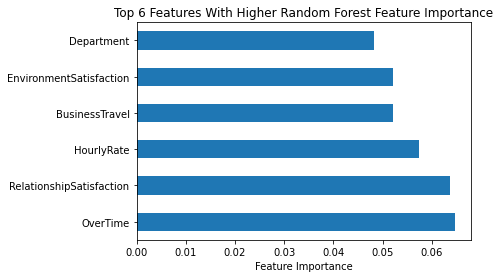

In [28]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, attDatafilt)

Logistic Regression(LR)

Confusion Matrix:
            Predicted Yes  No
Actual Yes            184  61
No                      9  40

Accuracy:
76.19 %

Cross Validation Accuracy:
77.48 %

Classification Report:
              precision    recall  f1-score   support

         Yes       0.95      0.75      0.84       245
          No       0.40      0.82      0.53        49

    accuracy                           0.76       294
   macro avg       0.67      0.78      0.69       294
weighted avg       0.86      0.76      0.79       294


Receiver Operating Characteristic(ROC):
Decision Tree(CART)

Confusion Matrix:
            Predicted Yes  No
Actual Yes            199  46
No                     31  18

Accuracy:
73.81 %

Cross Validation Accuracy:
81.28 %

Classification Report:
              precision    recall  f1-score   support

         Yes       0.87      0.81      0.84       245
          No       0.28      0.37      0.32        49

    accuracy                           0.74     

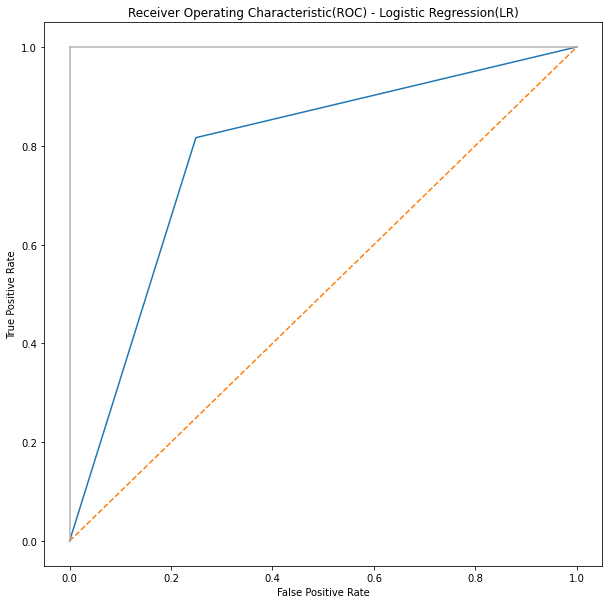

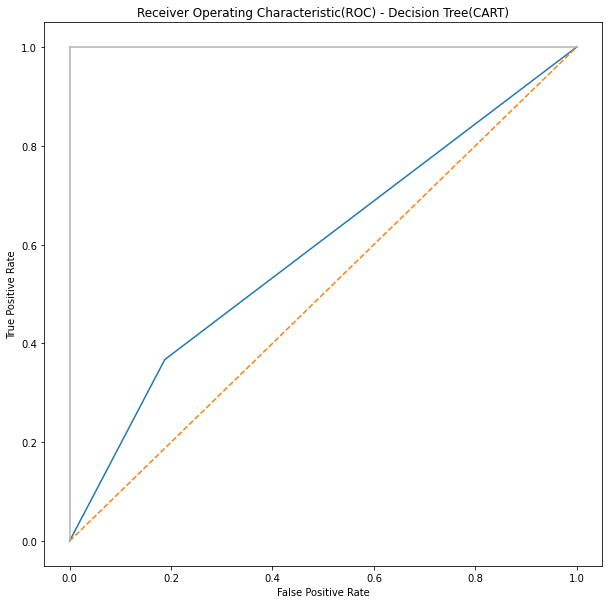

In [31]:
#Implement machine learning models to predict and gets the result of model and its performance metric values
result = mlPredict(X_train_smtom, y_train_smtom, Y_test) 

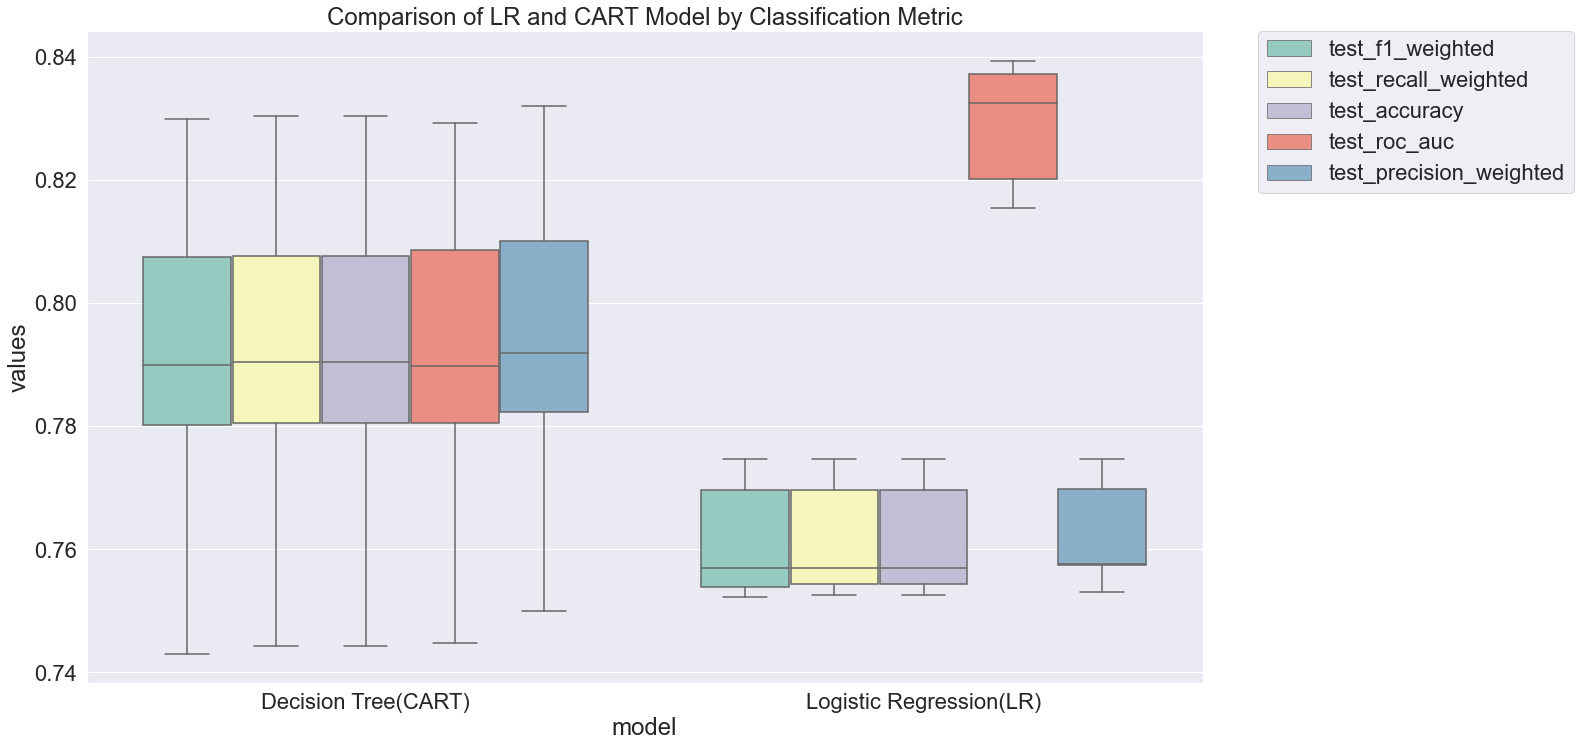

In [46]:
#Machine Learning models – Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [33]:
#Comparison of Performance metrics
metricValues = list(set(perf_results_nofit.metrics.values))
m_dataFrame.groupby(['model'])[metricValues].agg([np.std, np.mean]) #aggregate metric values with standard deviation and mean

test_accuracy           test_roc_auc            \
                                  std      mean          std      mean   
model                                                                    
Decision Tree(CART)          0.022007  0.799231     0.022605  0.799537   
Logistic Regression(LR)      0.013679  0.771456     0.014028  0.834178   

                        test_recall_weighted            \
                                         std      mean   
model                                                    
Decision Tree(CART)                 0.022007  0.799231   
Logistic Regression(LR)             0.013679  0.771456   

                        test_precision_weighted           test_f1_weighted  \
                                            std      mean              std   
model                                                                        
Decision Tree(CART)                    0.024211  0.802371         0.021909   
Logistic Regression(LR)                0.014087  0.772459         0.013676   

                                   
                             mean  
model                              
Decision Tree(CART)      0.798844  
Logistic Regression(LR)  0.771319

In [34]:
#Feature Selection 2 - Wrapper Method(Sequential Backward Selection using Linear Regression)
attDataWrap = attData #Create a copy of attData dataset
attDataWrap = transformToNumerical(attDataWrap) #Feature Encoding (To Numerical)
sel_features = featSelWrapper(attDataWrap) #Wrapper Method

After Encoding to numerical(First 10 records):

   Attrition  Age  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0          1   41               2       1102           2                 0   
1          0   49               1        279           1                20   
2          1   37               2       1373           1                 3   
3          0   33               1       1392           1                15   
4          0   27               2        591           1                 3   
5          0   32               1       1005           1                 3   
6          0   59               2       1324           1                15   
7          0   30               2       1358           1                 8   
8          0   38               1        216           1                 7   
9          0   36               2       1299           1                19   

   Education  EducationField  EnvironmentSatisfaction  Gender  ...  \
0          1           

In [35]:
#Splitting the Dataset to Train and Test
X_train, X_test, Y_train, Y_test = splitTrainTest(attDataWrap, attDataWrap[sel_features])

In [36]:
#Normalization of Dataset using z-score normalization
X_train, X_test = tranformationZScore(X_train, X_test)

Standardized or z-score Normalized Train and Test Dataset:

[[ 2.3389367   0.595307   -0.48557354 ...  0.22505569 -0.6134953
  -1.07224664]
 [ 0.9043263   0.595307    0.36465323 ...  0.22505569  0.1863611
   0.33038078]
 [ 0.35255307  0.595307   -1.23722329 ...  0.22505569  0.1863611
  -1.07224664]
 ...
 [ 0.68361701  0.595307    0.92900666 ...  0.22505569  0.1863611
   0.33038078]
 [ 0.13184377  0.595307   -1.31608491 ...  0.22505569 -2.21320809
  -2.47487406]
 [ 0.35255307  0.595307   -0.35495899 ...  0.22505569 -0.6134953
  -1.07224664]]
[[-0.08886552 -2.37113807 -0.41164077 ... -0.93068882  0.1863611
  -1.07224664]
 [-0.41992946  0.595307   -0.5595063  ... -0.93068882 -0.6134953
   0.33038078]
 [-0.19922017 -0.88791553 -0.34510129 ...  0.22505569 -2.21320809
  -1.07224664]
 ...
 [-0.64063875  0.595307   -1.36290899 ... -0.93068882  0.1863611
  -1.07224664]
 [ 0.13184377  0.595307    1.13108954 ... -0.93068882  0.1863611
   0.33038078]
 [ 0.35255307  0.595307   -1.06717794 ...  0.22

In [37]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.08607639 0.07202381 0.0664146  0.05030888 0.04884804 0.04701207
 0.04579305 0.04447958 0.04342344 0.04333051 0.04196873 0.04107871
 0.04048763 0.03926326 0.03858892 0.03725788 0.03690866 0.03599491
 0.03486831 0.03265893 0.02991674]


In [38]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({0: 988, 1: 188})
After Sampling:
Counter({0: 988, 1: 988})


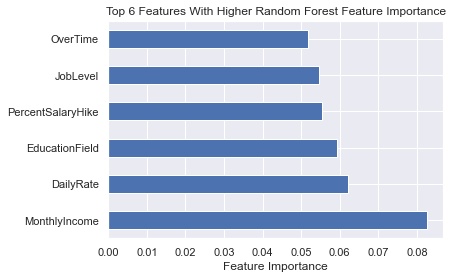

In [39]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, attDataWrap)

Logistic Regression(LR)

Confusion Matrix:
            Predicted Yes  No
Actual Yes            184  61
No                     10  39

Accuracy:
75.85 %

Cross Validation Accuracy:
76.42 %

Classification Report:
              precision    recall  f1-score   support

         Yes       0.95      0.75      0.84       245
          No       0.39      0.80      0.52        49

    accuracy                           0.76       294
   macro avg       0.67      0.77      0.68       294
weighted avg       0.86      0.76      0.79       294


Receiver Operating Characteristic(ROC):
Decision Tree(CART)

Confusion Matrix:
            Predicted Yes  No
Actual Yes            187  58
No                     29  20

Accuracy:
70.41 %

Cross Validation Accuracy:
80.11 %

Classification Report:
              precision    recall  f1-score   support

         Yes       0.87      0.76      0.81       245
          No       0.26      0.41      0.31        49

    accuracy                           0.70     

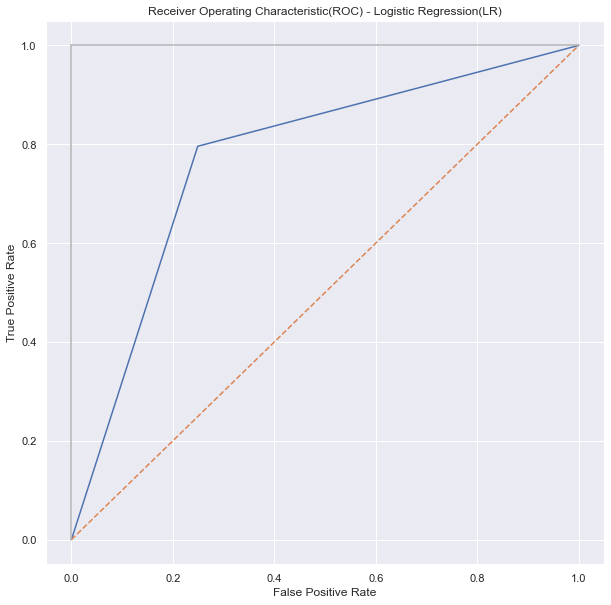

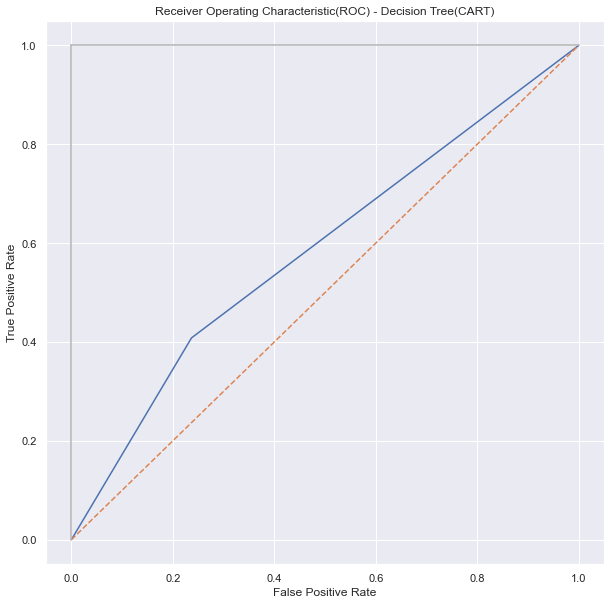

In [40]:
#Implement machine learning models to predict and gets the result of model and its performance metric values
result = mlPredict(X_train_smtom, y_train_smtom, Y_test) 

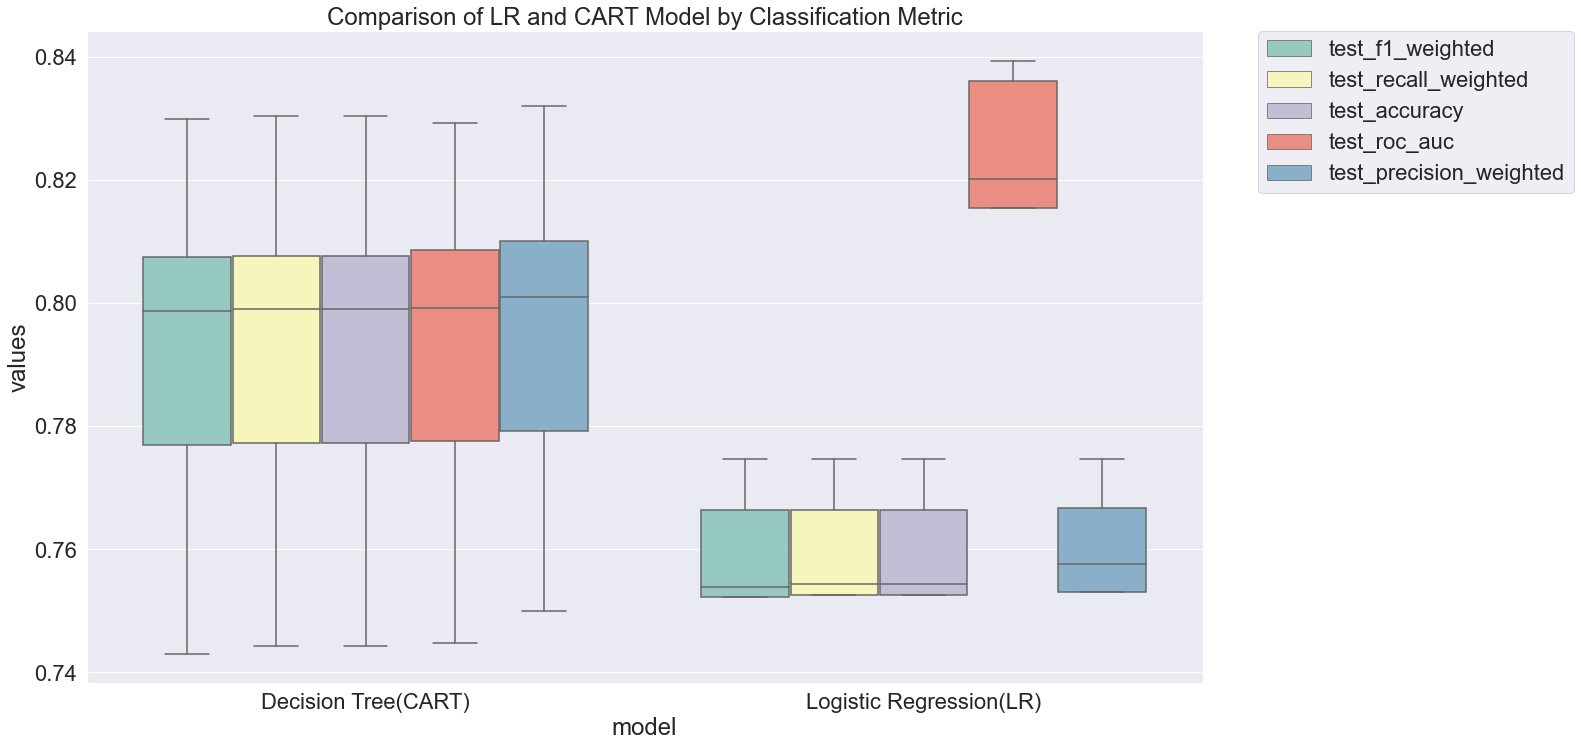

In [47]:
#Machine Learning models – Logistic regression and Decision tree to predict attrition and Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [48]:
#Comparison of Performance metrics
metricValues = list(set(perf_results_nofit.metrics.values))
m_dataFrame.groupby(['model'])[metricValues].agg([np.std, np.mean]) #aggregate metric values with standard deviation and mean

test_accuracy           test_roc_auc            \
                                  std      mean          std      mean   
model                                                                    
Decision Tree(CART)          0.028931  0.794874     0.028539  0.794863   
Logistic Regression(LR)      0.008339  0.758922     0.009604  0.825203   

                        test_recall_weighted            \
                                         std      mean   
model                                                    
Decision Tree(CART)                 0.028931  0.794874   
Logistic Regression(LR)             0.008339  0.758922   

                        test_precision_weighted           test_f1_weighted  \
                                            std      mean              std   
model                                                                        
Decision Tree(CART)                    0.027790  0.797388         0.029207   
Logistic Regression(LR)                0.007815  0.760075         0.008493   

                                   
                             mean  
model                              
Decision Tree(CART)      0.794417  
Logistic Regression(LR)  0.758669